In [1]:
from functools import reduce

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled


unit = 0.005

on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 250000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 500000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 500000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

data = reduce_correlation(shuffle(rv1, rv2, rv3, rv4), [0.0, 0.0, 0.0])

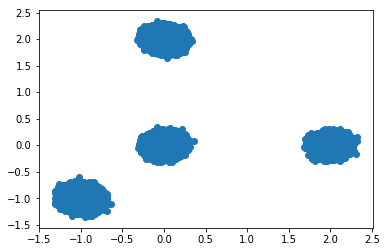

In [3]:
plt.scatter(data[:,0], data[:,1])

In [23]:
n_input = 3
n_latent = 1
n_layers = 2
n_hidden = 9

batch_size = 50

x = tf.placeholder("float32", [batch_size, n_input])

encoder_weights = []
encoder_biases = []
encoder_layers = []
encoder_layer = tf.layers.Dense(units=n_hidden, activation=tf.nn.sigmoid)
encoder_layers.append(encoder_layer)
applied_layer = encoder_layer.apply(x)
for i in range(n_layers - 1):
    encoder_layer = tf.layers.Dense(units=n_hidden, activation=tf.nn.sigmoid)
    encoder_layers.append(encoder_layer)
    applied_layer = encoder_layer.apply(applied_layer)
    
mn = tf.layers.Dense(units=n_latent)
applied_mn = mn.apply(applied_layer)
cov = tf.layers.Dense(units=n_latent)
applied_cov = cov.apply(applied_layer)
epsilon = tf.random_normal(tf.stack([batch_size, n_latent])) 
z = applied_mn + tf.multiply(epsilon, tf.exp(0.5 * applied_cov))

decoder_layers = []
decoder_layer = tf.layers.Dense(units=n_hidden, activation=tf.nn.sigmoid)
decoder_layers.append(decoder_layer)
applied_layer = decoder_layer.apply(z)
for i in range(n_layers - 1):
    decoder_layer = tf.layers.Dense(units=n_hidden, activation=tf.nn.sigmoid)
    decoder_layers.append(decoder_layer)
    applied_layer = decoder_layer.apply(applied_layer)
    
dec = tf.layers.Dense(units=n_input)
applied_dec = dec.apply(applied_layer)

feature_loss = tf.reduce_sum(tf.squared_difference(x, applied_dec), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + applied_cov - tf.square(applied_mn) - tf.exp(applied_cov), 1)
loss = tf.reduce_mean(feature_loss + latent_loss)

optimizer = tf.train.AdamOptimizer(0.005).minimize(loss)

In [32]:
class VariationalAutoEncoder(object):
    
    def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units, learning_rate=0.005):
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_latent_units = n_latent_units
        self.learning_rate = learning_rate
    
            
    class Encoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_latent_units = n_latent_units
            
        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []
            
        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]
        
        def add_mu(self, inputs):
            self.mu = tf.layers.Dense(units=self.n_latent_units)
            self.applied_mu = self.mu.apply(inputs)
            return self.applied_mu
            
        def add_sigma(self, inputs):
            self.sigma = tf.layers.Dense(units=self.n_latent_units)
            self.applied_sigma = self.sigma.apply(inputs)
            return self.applied_sigma
            
        def build(self, inputs):
            self.init_hidden_layers()
            
            layer = self.add_hidden_layer(inputs)
            
            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)
                
            mu = self.add_mu(layer)
            sigma = self.add_sigma(layer)
            
            return mu, sigma
            
            
    class Decoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_output_units):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_output_units = n_output_units
            
        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []
            
        def add_hidden_layer(self, inputs):
            self.hidden_layers.append(tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]
        
        def add_output(self, inputs):
            self.output = tf.layers.Dense(units=self.n_output_units)
            self.applied_output = self.output.apply(inputs)
            return self.applied_output
            
        def build(self, inputs):
            self.init_hidden_layers()
            
            layer = self.add_hidden_layer(inputs)
            
            for i in range(self.n_hidden_layers - 1):
                layer = self.add_hidden_layer(layer)
                
            output = self.add_output(layer)
            
            return output
        
        
    def sampled_z(self, mu, sigma, batch_size):
        epsilon = tf.random_normal(tf.stack([batch_size, self.n_latent_units])) 
        z = mu + tf.multiply(epsilon, tf.exp(0.5 * sigma))
        return z
    
    def build_losses(self, x, output, mu, sigma):
        feature_loss = tf.reduce_sum(tf.squared_difference(x, output), 1)
        latent_loss = -0.5 * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), 1)
        loss = tf.reduce_mean(feature_loss + latent_loss)
        
        return loss, feature_loss, latent_loss
        
    def train(self, data, batch_size=None, visualize=False):
        data_size = data.shape[0]
        if not batch_size:
            batch_size = int(data_size / 100)
            
        n_input = data.shape[-1]
                                    
        x = tf.placeholder("float32", [batch_size, n_input])
        
        encoder = self.Encoder(self.n_hidden_layers, self.n_hidden_units, self.n_latent_units)
        
        mu, sigma = encoder.build(x)
        
        z = self.sampled_z(mu, sigma, batch_size)
        
        decoder = self.Decoder(self.n_hidden_layers, self.n_hidden_units, n_input)
        
        output = decoder.build(z)
        
        loss, feature_loss, latent_loss = self.build_losses(x, output, mu, sigma)
        
        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        data_size = data.shape[0]
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            i = 0
            while (i * batch_size) < data_size:
                batch = data[i*batch_size:(i+1)*batch_size]
                sess.run(optimizer, feed_dict={x: batch})
                
                if visualize and (not i % int((data_size/batch_size)/3) or i == int(data_size/batch_size) - 1):
                    ls, d, f_ls, d_ls = sess.run([loss, output, feature_loss, latent_loss], feed_dict={x: batch})
                    plt.scatter(batch[:,0], batch[:,1])
                    plt.show()
                    plt.scatter(d[:,0], d[:,1])
                    plt.show()
                    print(i, ls, np.mean(f_ls), np.mean(d_ls))
            
                i += 1
            
        
        
class VariationalAutoEncoderModel(object):
    def init(self, encoder_model, decoder_model):
        self.encoder = encoder
        self.decoder = decoder

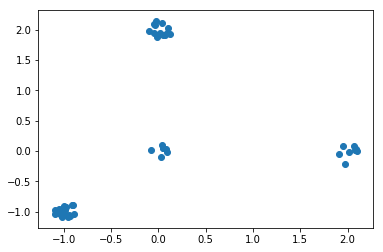

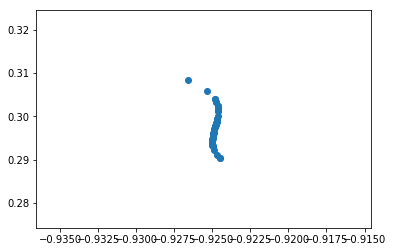

0 4.59185 4.59059 0.00125094


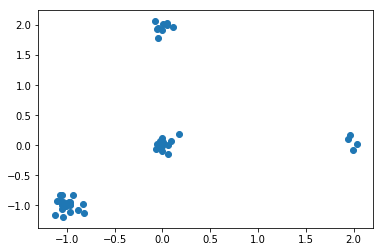

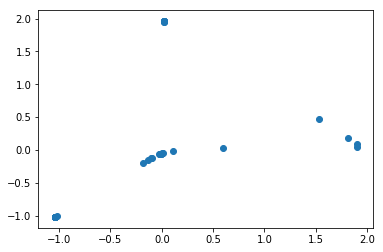

15000 1.56573 0.212149 1.35358


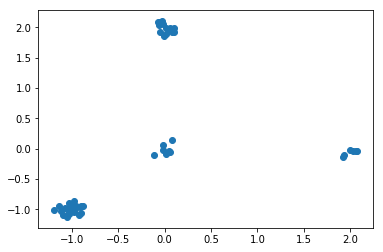

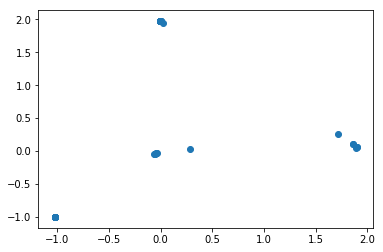

30000 1.4292 0.0275777 1.40163


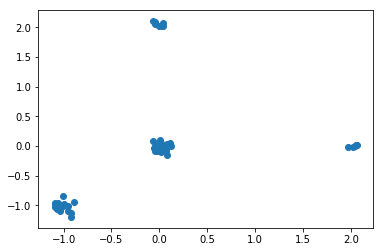

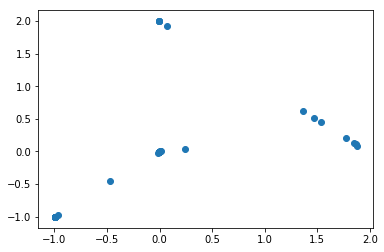

44999 1.67974 0.32249 1.35725


In [33]:
VariationalAutoEncoder(n_hidden_layers=3, n_hidden_units=9, n_latent_units=1, learning_rate=0.005)\
    .train(data, batch_size=50, visualize=True)